In [1]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

print("done")

done


In [2]:
#read vehicle and non vehicle images

basedir = 'vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))
    
print('Nuber of Vehicles: ', len(cars))

with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        
        
basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
    
print('Nuber of Non-Vehicles: ', len(notcars))

with open("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')


Nuber of Vehicles:  8792
Nuber of Non-Vehicles:  8968


In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
print("done")

done


In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

print("done")

done


In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

print("done")

done


In [6]:
# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    
    #Define an empty list to receive features
    features = []
    
    for file in imgs:
        file_features = []
        
        img = mpimg.imread(file)
        
        #Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      
        
        #Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #Append features to list
            file_features.append(spatial_features)
    
        # Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #Append features to list
            file_features.append(hist_features)
    
        # Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append features to list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))

    # Return concatenated array of features
    return features


print("done")

done


In [7]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

print("done")

done


In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print("done")

done


In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

print("done")

done


In [10]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

print("done")

done


In [11]:
# Function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap = 'hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

print("done")

done


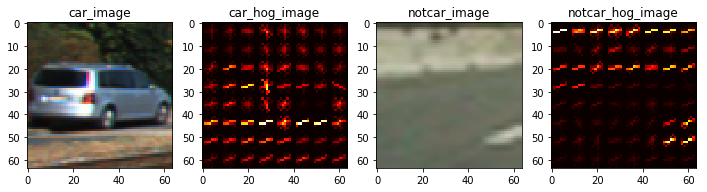

In [12]:
%matplotlib inline

car_ind = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features, car_hog_image = single_img_features(car_image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)


notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)


images = [car_image, car_hog_image, notcar_image, notcar_hog_image]

titles = ['car_image', 'car_hog_image', 'notcar_image', 'notcar_hog_image']

fig = plt.figure(figsize=(12,3))

visualize(fig, 1, 4, images, titles)

In [46]:
# Train a classifier

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)


notcar_features = extract_features(test_notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)



print (time.time()-t,'Seconds to compute features..')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('color_space: ', color_space,
'\norient: ', orient,
'\npix_per_cell: ', pix_per_cell,
'\ncell_per_block: ', cell_per_block,
'\nhog_channel: ', hog_channel,
'\nspatial_size: ', spatial_size,
'\nhist_bins: ', hist_bins)

print('Feature Vector length: ', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


118.98046398162842 Seconds to compute features..
color_space:  YCrCb 
orient:  9 
pix_per_cell:  8 
cell_per_block:  2 
hog_channel:  ALL 
spatial_size:  (32, 32) 
hist_bins:  32
Feature Vector length:  8460
15.82 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


0.6588070392608643 seconds to process one image searching 100  windows
0.5531859397888184 seconds to process one image searching 100  windows
0.5320119857788086 seconds to process one image searching 100  windows
0.534574031829834 seconds to process one image searching 100  windows
0.5571789741516113 seconds to process one image searching 100  windows
0.5709140300750732 seconds to process one image searching 100  windows


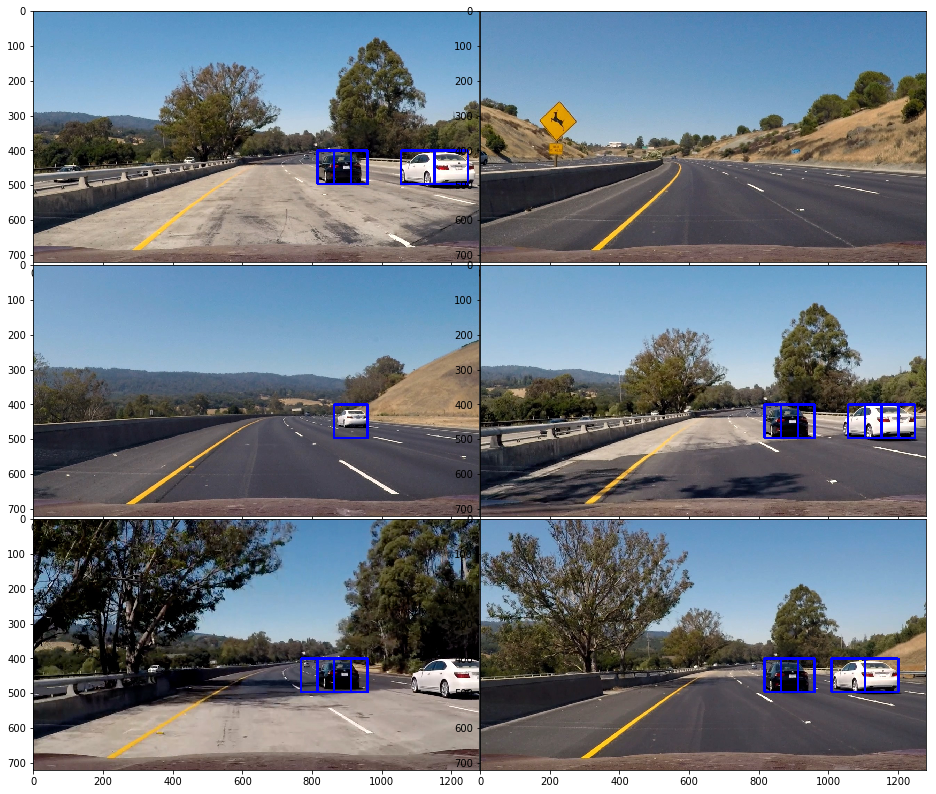

In [47]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400,656]
overlap = 0.5

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), ' windows')

fig = plt.figure(figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
visualize(fig, 3, 2, images, titles)

In [48]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [49]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

print("done")

done


0.5507099628448486 found 11  windows
0.4120490550994873 found 0  windows
0.4229750633239746 found 2  windows
0.40818095207214355 found 16  windows
0.40133190155029297 found 11  windows
0.40645885467529297 found 17  windows


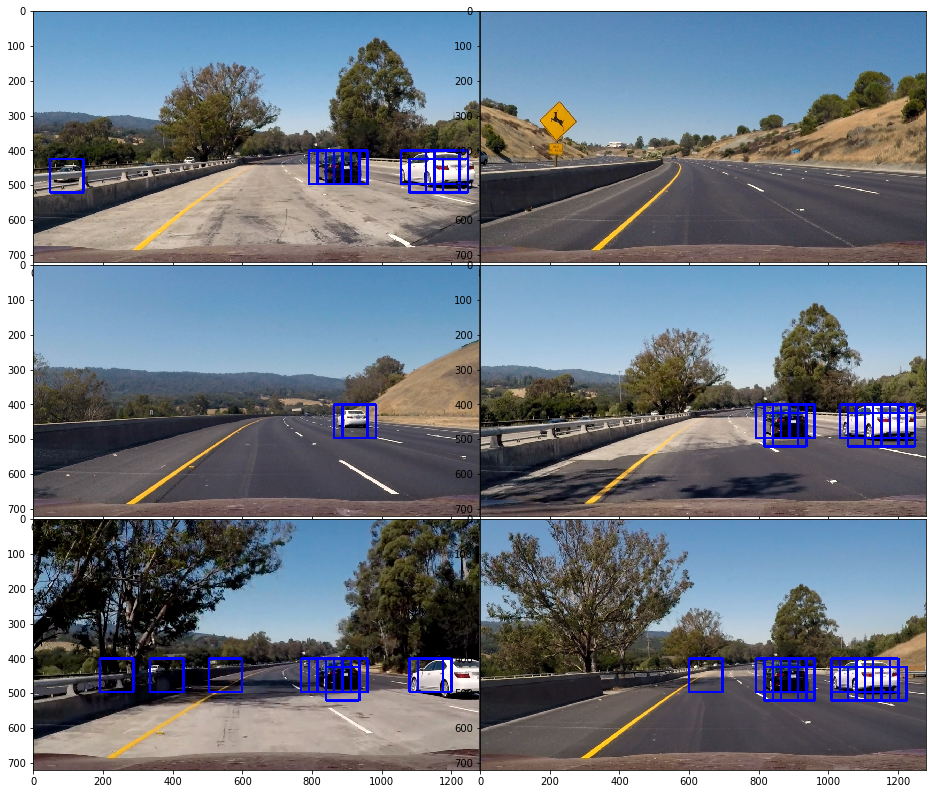

In [50]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    

    hot_windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'found', len(hot_windows), ' windows')

fig = plt.figure(figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
visualize(fig, 3, 2, images, titles)

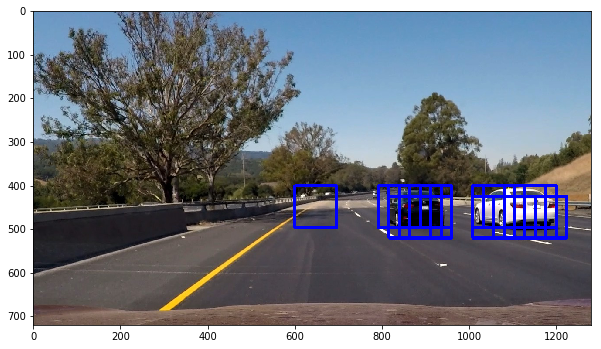

In [51]:
test_img = mpimg.imread('test_images/test6.jpg')
draw_img = np.copy(test_img)

ystart = 400
ystop = 656

# scale = 1
# hot_windows1 = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# scale = 1.5
# hot_windows = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# hot_windows1.extend(hot_windows)

# scale = 2
# hot_windows = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# hot_windows1.extend(hot_windows)

scale = 1.5
hot_windows = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6) 

plt.figure(figsize=(10,10))
plt.imshow(window_img)

In [52]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print("done")

done


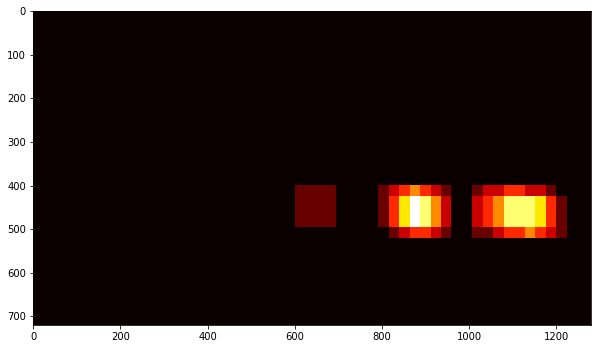

In [53]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, hot_windows)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

In [54]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print("done")

done


2 cars found


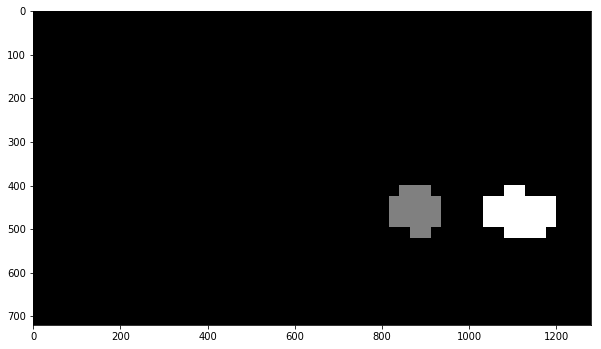

In [66]:
heatmap = apply_threshold(heatmap_img, 1)
labels = label(heatmap_img)
print(labels[1], 'cars found')
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')

In [56]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

print("done")

done


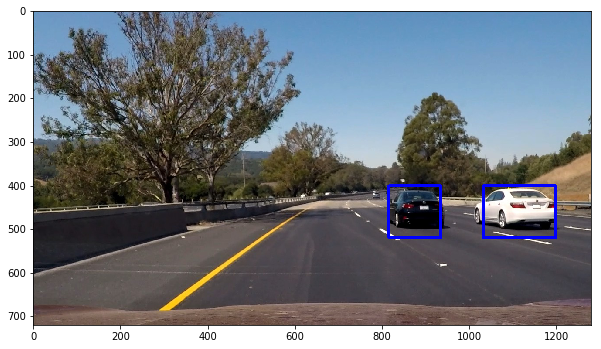

In [57]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [74]:
def process_image(img):
    
    ystart = 400
    ystop = 656
    scale = 1.5
    
    hot_windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(heatmap_img, hot_windows)
    
    heatmap = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img
    
print("done")


done


test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


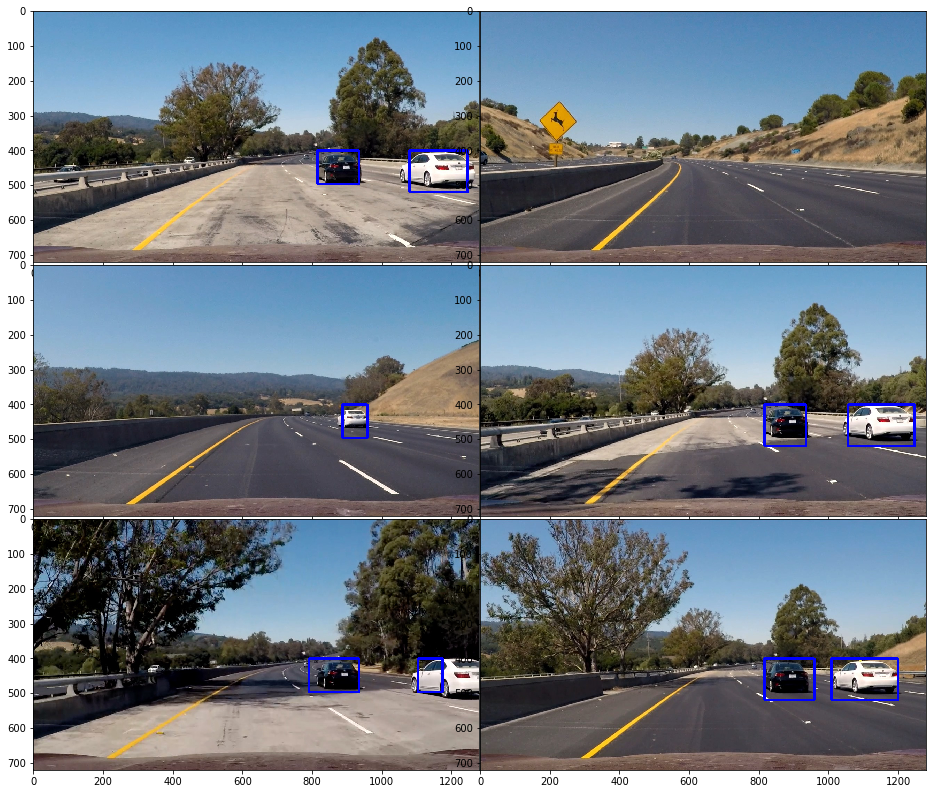

In [75]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
    print(img_src)
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    window_img = process_image(img)
                        
    images.append(window_img)
    titles.append('')

fig = plt.figure(figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
visualize(fig, 3, 2, images, titles)

In [76]:
# A class to store detected windows
class Vehicles():
    def __init__(self):
        # history of windows from previous n frames
        self.prev_windows = [] 
        
    def add_windows(self, windows):
        self.prev_windows.append(windows)
        if len(self.prev_windows) > 15:
            # remove oldest windows
            self.prev_windows = self.prev_windows[len(self.prev_windows)-15:]

print("done")

done


In [81]:
def process_frame(img):
    
    ystart = 400
    ystop = 656
    scale = 1.5
    
    hot_windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # add detections to the history
    if len(hot_windows) > 0:
        carlist.add_windows(hot_windows)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for windows in carlist.prev_windows:
        heatmap_img = add_heat(heatmap_img, windows)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(carlist.prev_windows)//2)
     
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

    
print("done")


done


In [82]:
carlist = Vehicles()
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:14<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 14.4 s, sys: 662 ms, total: 15 s
Wall time: 16.5 s


In [83]:
carlist = Vehicles()

test_out_file = 'project_video_output.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [3:00:57<00:00,  2.12it/s]     


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 8min 29s, sys: 22.2 s, total: 8min 51s
Wall time: 3h 59s
